# Retinal Disease Detection and Classification

## By: Jalen Wu, Yechan Na, Jonathan Zhang

__Project Description:__

The goal of this project is to develop a machine learning model capable of detecting retinal diseases by analyzing fundus images of the eye. Using computer vision and deep learning techniques, the model assists in early detection and diagnosis of retinal disease(s).

__Applications and Impact:__

This project could be used for clinical screening to help ophthalmologists identify diseases and improve efficiency on identifying these diseases. This automated detection system has the potential to make medical imaging diagnostics more accessible.

__What we hope to achieve:__

We hope to build a model that takes in images of the eye and accurately predicts whether an individual’s eyes are healthy or showing signs of disease. To quantify the effectiveness of our model, we will be measuring metrics such as F1 score, precision, recall, loss, and accuracy of our models and graphing them as a function of how many epochs we run on our training data (all of these scores should increase in subsequent epochs).

- __Dataset__: https://www.kaggle.com/datasets/andrewmvd/retinal-disease-classification/data
- __References__: 
    - https://www.mdpi.com/2306-5729/6/2/14
    - https://jamanetwork.com/journals/jama/fullarticle/2588763
    

In [1]:
# imports

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import os
from torch.utils.data import Dataset
import pandas as pd
from skimage import io, transform
from torch import tensor
from PIL import Image
from torch import flatten

In [2]:
# Import Dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/retinal-disease-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\wendy\.cache\kagglehub\datasets\andrewmvd\retinal-disease-classification\versions\1


In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
# X = 1424 x 2144 x 3 : h x w x colors
# y = label
transform = transforms.Compose([
    transforms.Resize((int(1424 / 8), int(2144 / 8))), # Standardize image dimensions to 1444 x 2144
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

base_directory = path  
print(base_directory)

if os.path.exists(base_directory):
    print("Directory exists and its contents are:")
    print(os.listdir(base_directory))
else:
    print("Directory does not exist.")

C:\Users\wendy\.cache\kagglehub\datasets\andrewmvd\retinal-disease-classification\versions\1
Directory exists and its contents are:
['Evaluation_Set', 'Test_Set', 'Training_Set']


In [5]:
# Constants (paths that will be accessed later in the project)
BASE_DIRECTORY = path
TRAINING_DIRECTORY = os.path.join(BASE_DIRECTORY, 'Training_Set', 'Training_Set', 'Training')
TRAINING_LABELS = os.path.join(BASE_DIRECTORY, 'Training_Set', 'Training_Set', 'RFMiD_Training_Labels.csv')
TESTING_DIRECTORY = os.path.join(BASE_DIRECTORY, 'Test_Set', 'Test_Set', 'Test')
TESTING_LABELS = os.path.join(BASE_DIRECTORY, 'Test_Set', 'Test_Set', 'RFMiD_Testing_Labels.csv')

In [6]:
class MultiClassDataset(Dataset):
    """
    Supports structure of given dataset (images in child folder and labels in csv format).
    """
    def __init__(self, label_csv_file, image_directory, transform=None):
        """
        Args:
            label_csv_file (str): Path to the CSV label file.
            image_directory (str): Directory with eye images.
            transform (callable, optional): transform function to be applied to each image.
        """
        self.label_csv_file = pd.read_csv(label_csv_file)
        self.image_directory = image_directory
        self.transform = transform
    
    def __len__(self):
        return len(self.label_csv_file)    

    def __getitem__(self, index):
        """
        Args:
            index: the index of the image/label pair we want to retrieve
            
        Returns:
            image_and_label (dict): A dictionary containing the image and its corresponding label at the requested index.
        """

        # The images are PNG and one-indexed (1.png, 2.png, 3.png, ...)
        image_path = os.path.join(self.image_directory, str(index + 1) +'.png')
        
        image_label = self.label_csv_file.loc[index]
        image_label = image_label.to_numpy()
        image_label = image_label[1:]
        image_label = tensor(image_label)
        
        # Loads image at the given path.
        current_image = io.imread(image_path)
        
        if current_image is None or current_image.size == 0:
            raise ValueError(f"Failed to load image: {image_path}")
       
        # Convert to PIL Image
        current_image = Image.fromarray(current_image)
        
        # If transform function passed in, apply transform to image
        if self.transform:
            transformed_image = self.transform(current_image)
            return {'image': transformed_image, 'label': image_label}
        
        return {'image': current_image,'label': image_label}

In [7]:
# Initializing dataset and loader.
train_dataset = MultiClassDataset(label_csv_file=TRAINING_LABELS, image_directory=TRAINING_DIRECTORY, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64)

# Visualize loader
res = next(iter(train_loader))
print(res['image'].shape)
print(res['label'].shape)

print(res['label'][0])
print(res['image'][0][0])

torch.Size([64, 3, 178, 268])
torch.Size([64, 46])
tensor([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [8]:
# image tensor format: [batch_size, channels, height, width]
print(res['image'][0].shape)

torch.Size([3, 178, 268])


In [24]:
import torch.nn as nn
import torch.nn.functional as F


class Conv_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 16, 5)
        self.fc1 = nn.Linear(41328, 1200)
        self.fc2 = nn.Linear(1200, 840)
        self.fc3 = nn.Linear(840, 230)
        self.fc4 = nn.Linear(230, 46)
        #self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x


conv_model = Conv_NN()

In [15]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(conv_model.parameters(), lr=0.001, momentum=0.9)

In [25]:
n = 20
def train(dataloader, model, loss_fn, optimizer):
    model.eval()
    size = len(dataloader.dataset)
    total_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['image']
        labels = data['label']
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_loss += loss.item()
        if i % n == n-1:    # print every n mini-batches
            print(f'{i + 1:5d} loss: {running_loss / n:.3f}')
            running_loss = 0.0
    
    return total_loss/size

In [26]:
epochs = 40
conv_model_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    conv_loss = train(train_loader, conv_model, loss_fn, optimizer)
    print("conv_loss: ", conv_loss)
    
    if t > 3 and conv_loss > conv_model_loss[-1]:
        break
    
    conv_model_loss.append(conv_loss)
    torch.save(conv_model.state_dict(), "conv_model.pth")

Epoch 1
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 2
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 3
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 4
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 5
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 6
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 7
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 8
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 9
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 10
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 11
-------------------------------
   20 loss: 7.707
conv_loss:  0.11186706485847632
Epoch 12

# Analysis
- Plot loss/accuracy (y) with number of epochs ran (x)
- Recall/Precision/F1 score 

In [18]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    correct_each = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['image']
            labels = data['label']

            preds = model(inputs)
            for p_i in range(len(preds)):
                for l_i in range(len(preds[p_i])):
                    if preds[p_i][l_i] > 0.9:
                        preds[p_i][l_i] = 1.0
                    else:
                        preds[p_i][l_i] = 0.0
            # TODO: look at (preds == labels)
            for row in (preds == labels):
                all_correct = 1
                for equal in row:
                    if not equal:
                        all_correct = 0
                        break
                correct += all_correct
            correct_each += (preds == labels).type(torch.float).sum().item()/len(preds[0])
            print(correct, correct_each)
    
    accuracy = correct/size
    accuracy_each = correct_each/size
    print("accuracy:", accuracy)
    print("accuracy_each:", accuracy_each)

In [19]:
test_dataset = MultiClassDataset(label_csv_file=TESTING_LABELS, image_directory=TESTING_DIRECTORY, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64)

In [28]:
print("Convolutional Model")
test(test_loader, conv_model)

Convolutional Model
0 60.58695652173913
0 121.28260869565219
0 182.1521739130435
1 243.23913043478262
15 304.5869565217391
27 365.9130434782609
37 427.1304347826087
61 489.0869565217391
104 552.1739130434783
134 614.4565217391304
accuracy: 0.209375
accuracy_each: 0.9600883152173912


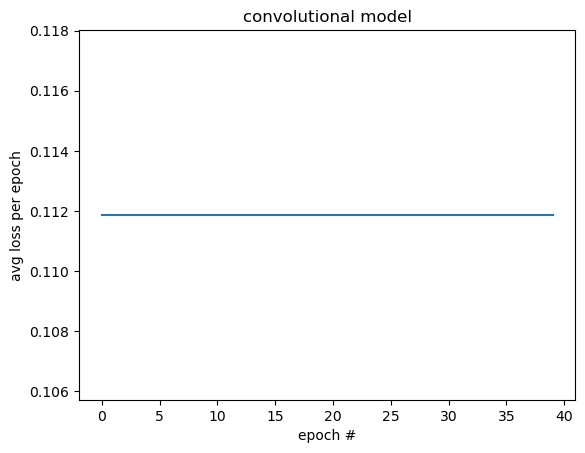

[0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632, 0.11186706485847632]


In [27]:
def graph_loss(x, y, graph_name):

    plt.plot(x, y)
    plt.xlabel("epoch #")
    plt.ylabel("avg loss per epoch")
    plt.title(graph_name)
    plt.show()
    
graph_loss(range(len(conv_model_loss)), conv_model_loss, "convolutional model")
print(conv_model_loss)